<a href="https://colab.research.google.com/github/tettey-exploits/conditional_gan_for_fashion_mnist_image_generation/blob/main/Conditional_GAN_for_Image_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Conditional GAN for Image Generation

**Description:**
This notebook demonstrates the process of building a Conditional Generative Adversarial Network (GAN) to generate images of handwritten digits or clothing items. The GAN is conditioned on class labels, allowing the generation of images corresponding to specific classes.

In [1]:
# Import necessary libraries
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F

In [2]:
# Function to display images
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Displays a grid of images from a tensor.

    Args:
    image_tensor: Tensor containing image data
    num_images: Number of images to display
    size: Size of each image
    nrow: Number of rows in the grid
    show: Whether to display the images
    '''
    image_tensor = (image_tensor + 1) / 2  # Rescale images to 0-1
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    if show:
        plt.imshow(image_grid.permute(1, 2, 0).squeeze())
        plt.show()

# Loading the MNIST or FashionMNIST dataset
dataset = datasets.FashionMNIST  # datasets.MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = dataset(root='data', train=True, transform=transform, download=True)
dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)


100%|██████████| 26421880/26421880 [00:12<00:00, 2133002.05it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 202481.04it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3777444.20it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21210488.20it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



### Generator and Noise


In [3]:
class Generator(nn.Module):
    '''
    A class representing the Generator in the GAN.

    Args:
        input_dim: Dimension of the input vector (noise + class vector).
        im_chan: Number of channels in the output image (1 for grayscale).
        hidden_dim: Inner dimension of the generator layers.
    '''
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Building the generator neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )


    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Creates a generator block for the GAN.

        Args:
            input_channels: Number of input channels.
            output_channels: Number of output channels.
            kernel_size: Size of the convolutional kernel.
            stride: Stride for the convolution.
            final_layer: Boolean, if True, the final layer of the generator.

        Returns:
            A sequential block of layers.
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else:  # Final layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    # def forward(self, noise):
    #     '''
    #     Forward pass through the generator.

    #     Args:
    #         noise: Input noise and class vector.

    #     Returns:
    #         Generated image.
    #     '''
    #     return self.gen(noise)

    def forward(self, noise):
      '''
      Completes a forward pass of the generator network.

      Args:
          noise: A tensor representing noise and class vectors.

      Returns:
          A generated image tensor.
      '''
      x = noise.view(len(noise), self.input_dim, 1, 1)
      return self.gen(x)


# Function to generate random noise vectors
def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Generates noise vectors for the GAN input.

    Args:
        n_samples: Number of noise vectors to generate.
        input_dim: Dimension of each noise vector.
        device: Device on which to create the noise (CPU or GPU).

    Returns:
        A tensor of random noise.
    '''
    return torch.randn(n_samples, input_dim, device=device)



### Discriminator

In [4]:
class Discriminator(nn.Module):
    '''
    Values:
      im_chan: the number of channels in the images, fitted for the dataset used, a scalar
            (MNIST is black-and-white, so 1 channel is your default)
      hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [5]:
def get_one_hot_labels(labels, n_classes):
    '''
    Converts class labels to one-hot encoded vectors.

    Args:
        labels: Tensor of class labels.
        n_classes: Total number of classes in the dataset.

    Returns:
        Tensor of shape (batch_size, n_classes) representing one-hot encoded labels.
    '''
    return F.one_hot(labels, num_classes=n_classes)


## Combining Class and Noise Vectors

Before passing the input to the generator or discriminator, we concatenate the one-hot encoded class vector to the noise vector (or the image for the discriminator). This ensures that both class information and random noise are accounted for in the input.


In [6]:
def combine_vectors(x, y):
    '''
    Concatenates two vectors along the feature dimension.

    Args:
        x: Tensor representing the first vector (e.g., noise vector).
        y: Tensor representing the second vector (e.g., one-hot encoded class vector).

    Returns:
        A concatenated tensor of shape (n_samples, combined_dim).
    '''
    combined = torch.cat((x.float(), y.float()), dim=1)
    return combined


## Training the GAN

Now, we can start training the GAN. We define parameters specific to the dataset and model to prepare for training:


In [7]:
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    '''
    Calculates the input dimensions for the generator and discriminator in a Conditional GAN.

    Args:
        z_dim: Dimensionality of the noise vector.
        mnist_shape: Shape of each MNIST image in the format (C, W, H) where
                     C is the number of channels, and W, H are width and height.
        n_classes: Total number of classes in the dataset (e.g., 10 for MNIST).

    Returns:
        generator_input_dim: The combined dimensionality of the generator input
                             (noise vector and class vector).
        discriminator_im_chan: The number of input channels for the discriminator,
                               accounting for class embedding.
    '''
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = mnist_shape[0] + n_classes
    return generator_input_dim, discriminator_im_chan

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Set device to GPU if available

# Hyperparameters
beta1 = 0.5  # Hyperparameter for Adam optimizers
noise_dim = 100  # Dimension of the noise vector
num_classes = 10  # Number of classes in the dataset
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
learning_rate = 0.0002
mnist_shape = (1, 28, 28)

In [9]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, num_classes)

gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=learning_rate)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=learning_rate)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/469 [00:00<?, ?it/s]

Model Training


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: 2.178023332953453, discriminator loss: 0.23478087861835956


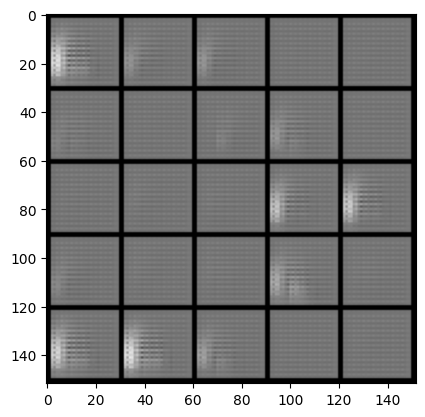

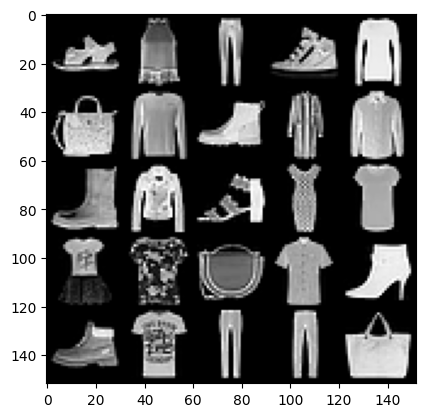

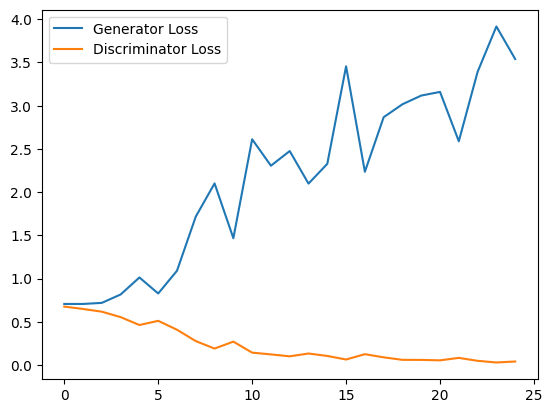

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: 3.433362505674362, discriminator loss: 0.10894263915345073


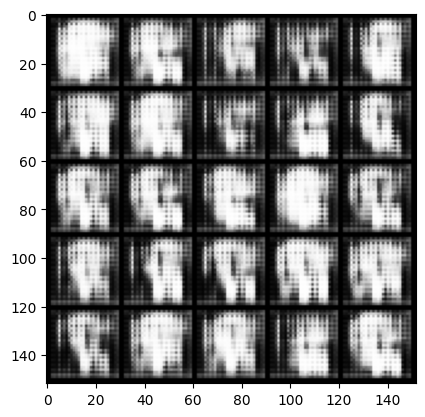

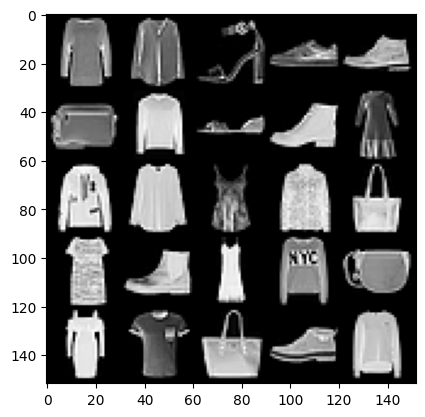

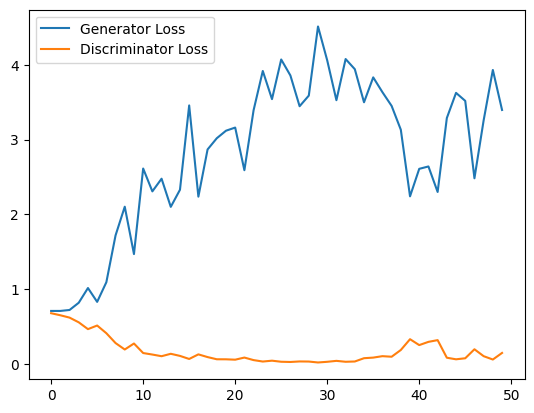

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1500: Generator loss: 2.1793298979997635, discriminator loss: 0.3568263546153903


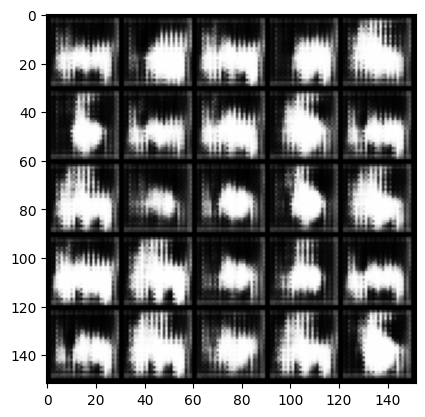

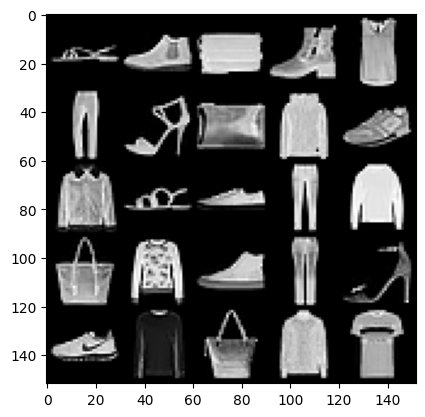

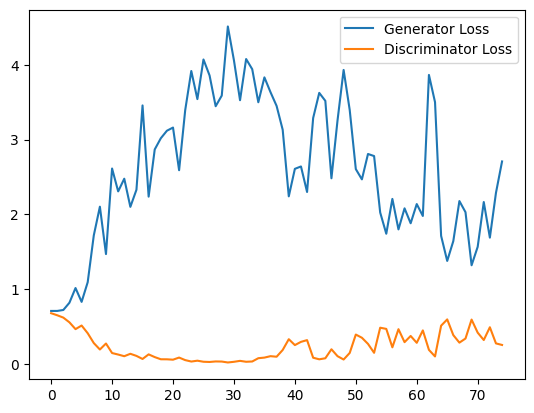

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 2000: Generator loss: 2.121381793022156, discriminator loss: 0.29359592290222647


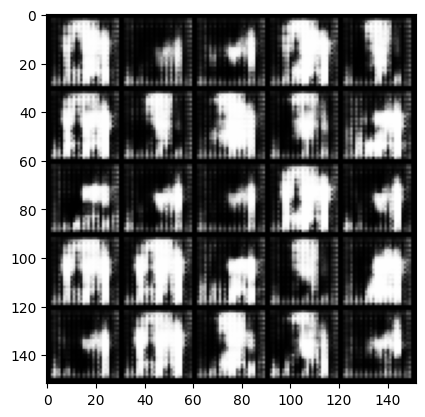

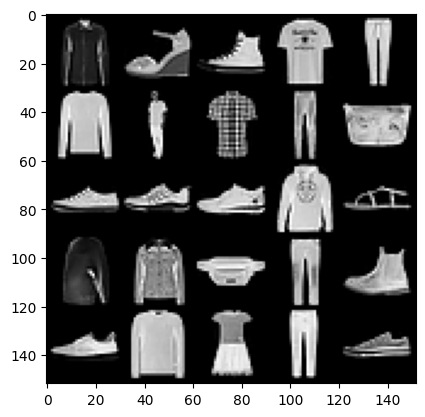

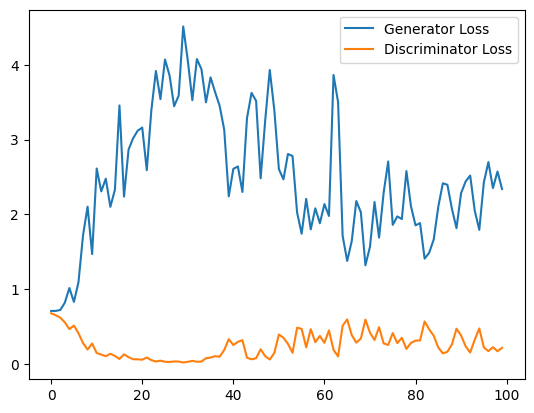

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, step 2500: Generator loss: 2.2043656980991364, discriminator loss: 0.30438224638998507


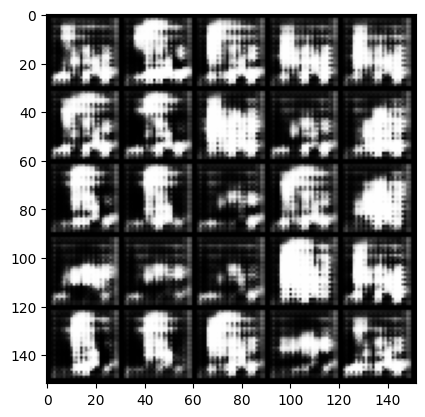

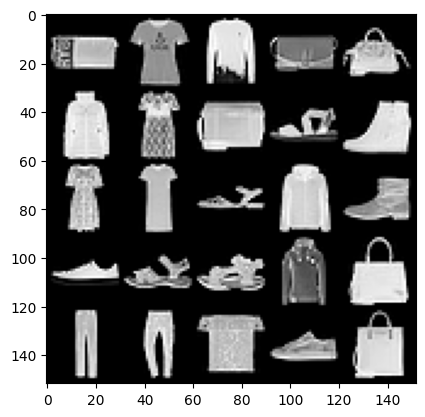

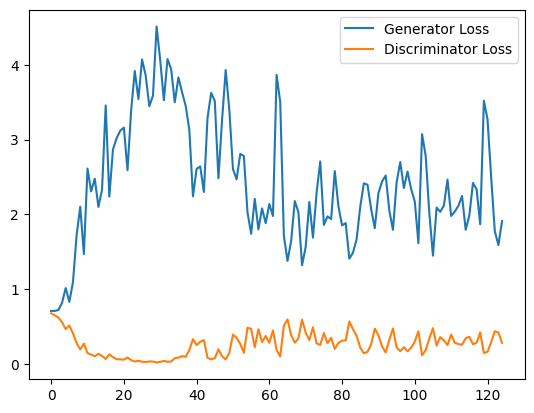

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, step 3000: Generator loss: 2.124147793292999, discriminator loss: 0.3169264463484287


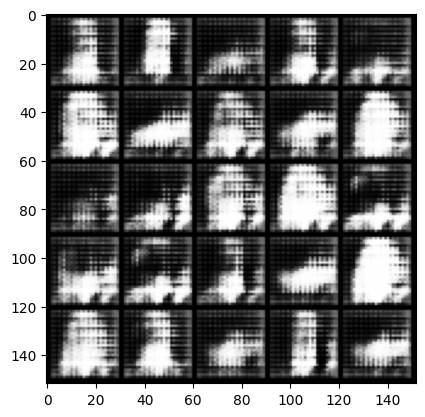

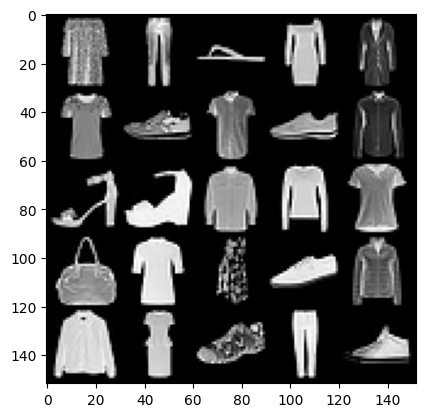

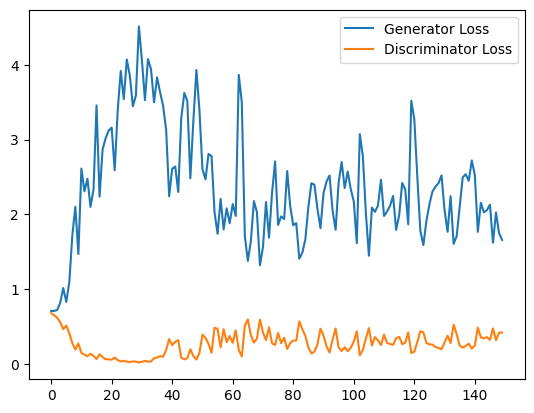

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, step 3500: Generator loss: 1.7051566400527953, discriminator loss: 0.37090249681472776


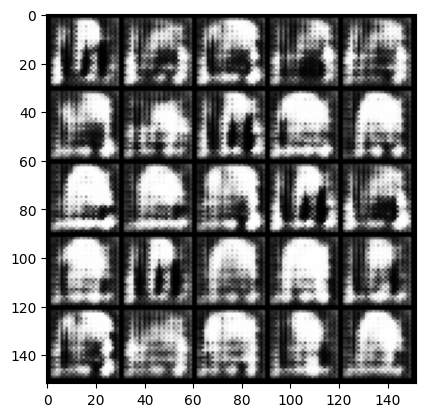

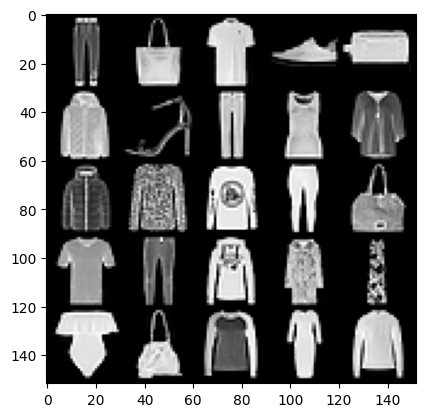

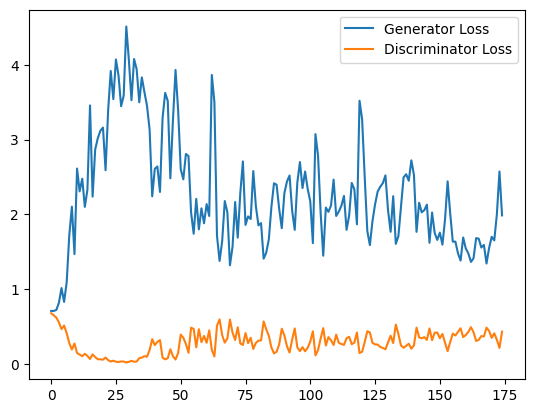

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, step 4000: Generator loss: 1.892476189494133, discriminator loss: 0.3649928095638752


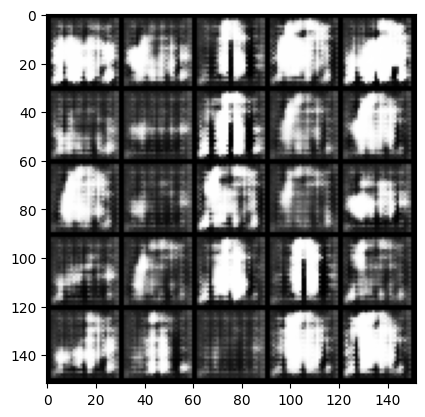

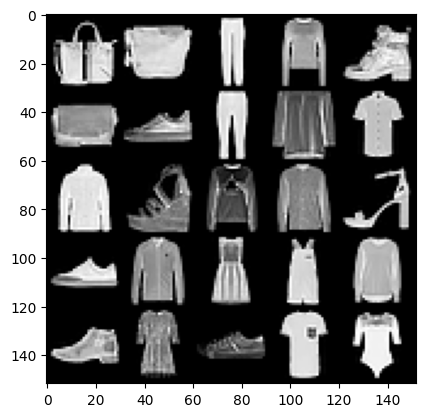

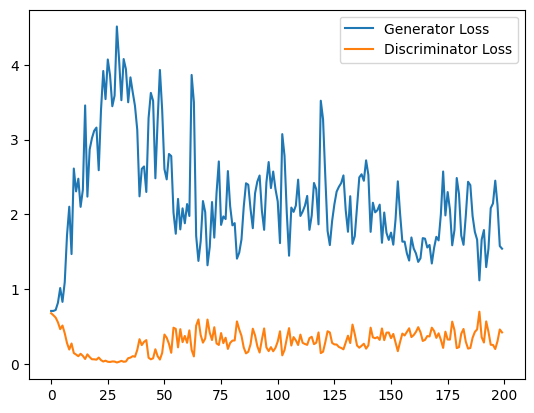

In [ ]:
cur_step = 0
generator_losses = []
discriminator_losses = []

noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs):
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)

        one_hot_labels = get_one_hot_labels(labels.to(device), num_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

        ### Update discriminator ###
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)

        noise_and_labels = combine_vectors(fake_noise, one_hot_labels)  # Combine the noise vectors and the one-hot labels for the generator
        fake = gen(noise_and_labels)  # Generate the conditioned fake images

        fake_image_and_labels = combine_vectors(fake.detach(), image_one_hot_labels)
        real_image_and_labels = combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels)  # Get the discriminator's prediction on the fakes as disc_fake_pred
        disc_real_pred = disc(real_image_and_labels)  # Get the discriminator's prediction on the reals as disc_real_pred

        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        # This will error if you didn't concatenate your labels to your image correctly
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Model Training")
        cur_step += 1

In [ ]:
# # Labels for real and fake data
# real_label = 1.
# fake_label = 0.

# # Training Loop
# for epoch in range(n_epochs):
#     for real_images, labels in tqdm(dataloader):
#         cur_batch_size = real_images.size(0)
#         real_images = real_images.to(device)
#         labels = labels.to(device)

#         ##############################################
#         # Update Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
#         ##############################################
#         disc_opt.zero_grad()

#         # Prepare real images and labels
#         real_labels_onehot = torch.nn.functional.one_hot(labels, num_classes).float().to(device)
#         real_images_with_labels = torch.cat([real_images, real_labels_onehot.unsqueeze(2).unsqueeze(3).expand(-1, -1, 28, 28)], dim=1)

#         # Discriminator loss on real images
#         disc_real_pred = disc(real_images_with_labels).view(-1)
#         disc_real_loss = criterion(disc_real_pred, torch.full((cur_batch_size,), real_label, device=device))

#         # Generate fake images
#         noise = get_noise(cur_batch_size, noise_dim, device=device)
#         fake_labels = torch.randint(0, num_classes, (cur_batch_size,), device=device)
#         fake_labels_onehot = torch.nn.functional.one_hot(fake_labels, num_classes).float().to(device)
#         noise_with_labels = torch.cat([noise, fake_labels_onehot], dim=1)
#         fake_images = gen(noise_with_labels)

#         # Prepare fake images and labels
#         fake_images_with_labels = torch.cat([fake_images.detach(), fake_labels_onehot.unsqueeze(2).unsqueeze(3).expand(-1, -1, 28, 28)], dim=1)

#         # Discriminator loss on fake images
#         disc_fake_pred = disc(fake_images_with_labels).view(-1)
#         disc_fake_loss = criterion(disc_fake_pred, torch.full((cur_batch_size,), fake_label, device=device))

#         # Total discriminator loss
#         disc_loss = disc_real_loss + disc_fake_loss
#         disc_loss.backward()
#         disc_opt.step()

#         ##############################################
#         # Update Generator: maximize log(D(G(z)))
#         ##############################################
#         gen_opt.zero_grad()

#         # Generate fake images for generator update
#         noise = get_noise(cur_batch_size, noise_dim, device=device)
#         fake_labels = torch.randint(0, num_classes, (cur_batch_size,), device=device)
#         fake_labels_onehot = torch.nn.functional.one_hot(fake_labels, num_classes).float().to(device)
#         noise_with_labels = torch.cat([noise, fake_labels_onehot], dim=1)
#         fake_images = gen(noise_with_labels)
#         fake_images_with_labels = torch.cat([fake_images, fake_labels_onehot.unsqueeze(2).unsqueeze(3).expand(-1, -1, 28, 28)], dim=1)

#         # Generator loss
#         disc_fake_pred = disc(fake_images_with_labels).view(-1)
#         gen_loss = criterion(disc_fake_pred, torch.full((cur_batch_size,), real_label, device=device))
#         gen_loss.backward()
#         gen_opt.step()

#     # Display progress
#     print(f"Epoch [{epoch+1}/{n_epochs}] | Generator Loss: {gen_loss.item():.4f} | Discriminator Loss: {disc_loss.item():.4f}")

#     # Visualize generated images
#     if (epoch + 1) % 10 == 0:
#         with torch.no_grad():
#             test_noise = get_noise(25, noise_dim, device=device)
#             test_labels = torch.arange(num_classes).repeat(2, 1).transpose(0,1).flatten().to(device)[:25]
#             test_labels_onehot = torch.nn.functional.one_hot(test_labels, num_classes).float()
#             test_input = torch.cat([test_noise, test_labels_onehot], dim=1)
#             generated = gen(test_input)
#             show_tensor_images(generated.cpu(), num_images=25, nrow=5)
